In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec


import seaborn as sns
%matplotlib inline 

from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GroupKFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import *


import xgboost as xgb
import lightgbm as lgb

from sklearn.preprocessing import PowerTransformer


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels import tsa
from scipy import stats

import sys, os
import random 

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
from IPython.display import display
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

def set_seed(seed=2021):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:

dtypes = {
    "DEvenRLC": "int32",
    "HEvenRLC": "int32",
    "InstrumentID": "str",
    "DSeaBsEven": "int32",
    "NTranSeaBs": "int32",
    "QTitTran": "int32",
    "PTran": "float32",
    "IAnuTran": "float32",
    "buyer_trader": "float32", 
    "buyer": "float32",
    "Buy_PLimSaiOm":"float32",
   "Buy_NSeqOm10":"float32",
   "Buy_DHSaiOmAdf": "float32",
   "seller_trader":"float32",
   "seller":"float32",
   "sell_PLimSaiOm":"float32",
   "sell_NSeqOm10":"float32",
   "sell_DHSaiOmAdf":"float32"
    
    
}

data = pd.read_csv("data-final.csv", dtype=dtypes)

print("Train size:", data.shape)
data.info()




In [3]:
def conf_dt(data):
    data['datetime'] =  pd.to_datetime(data.DEvenRLC.astype(str)+data.HEvenRLC.astype(str), format='%Y%m%d%H%M%S') 
    display(data[['DEvenRLC', 'HEvenRLC', 'datetime']].head(20))
    del data['DEvenRLC']
    del data['HEvenRLC']
    del data['DSeaBsEven']
    return data

def samp_ts(df, f, t):
    if t==0:
        df = df[(df.DEvenRLC > f)]
        
    else:
           
        df = df[(df.DEvenRLC > f) & (df.DEvenRLC <t)]
        
            
    return df 
            
def firstLevFE(data):
    data['Price'] = data.PTran.values / data.QTitTran.values
    drops = ['DSeaBsEven', 'IAnuTran', 'Buy_NSeqOm10','sell_NSeqOm10','Buy_DHSaiOmAdf','sell_DHSaiOmAdf'   ]
    data.drop(drops, axis=1, inplace=True)
    to_int = ['buyer_trader', 'buyer', 'seller_trader', 'seller']
    for c in to_int:
        data[c] = data[c].astype(int)
    display(data.info())
    return data

data.to_pickle('all_data_reduced.pkl')

data.shape

#### **All Data Reduced**

In [3]:
data = pd.read_pickle('all_data_reduced.pkl')

In [4]:
data.shape

(72929669, 18)

In [5]:
data.head()

,DEvenRLC,HEvenRLC,InstrumentID,DSeaBsEven,NTranSeaBs,QTitTran,PTran,IAnuTran,buyer_trader,buyer,Buy_PLimSaiOm,Buy_NSeqOm10,Buy_DHSaiOmAdf,seller_trader,seller,sell_PLimSaiOm,sell_NSeqOm10,sell_DHSaiOmAdf
0,20190819,111557,IRO7MINP0001,20190819,286,5000,21750.0,7.0,1570.0,2478401.0,21750.0,812.0,2.019082e+13,1452.0,2344298.0,21700.0,831.0,2.019082e+13
1,20190819,111557,IRO7MINP0001,20190819,287,5000,21750.0,7.0,1570.0,2478401.0,21750.0,820.0,2.019082e+13,1452.0,2344298.0,21700.0,831.0,2.019082e+13
2,20190819,111540,IRO7SFSP0001,20190819,3172,1693,5850.0,7.0,1371.0,2258853.0,5880.0,6756.0,2.019082e+13,639.0,1410577.0,5850.0,6754.0,2.019082e+13
3,20190819,111540,IRO7SFSP0001,20190819,3175,32307,5880.0,7.0,1371.0,2258853.0,5880.0,6756.0,2.019082e+13,586.0,1385851.0,5880.0,6713.0,2.019082e+13
4,20190818,122125,IRO3KAHZ0001,20190818,2181,46557,11307.0,7.0,569.0,1377126.0,11307.0,3336.0,2.019082e+13,1393.0,2272905.0,11300.0,3606.0,2.019082e+13


In [6]:
data.DEvenRLC.min(),data.DEvenRLC.max()

(20170611, 20191201)

In [7]:
data.DSeaBsEven.min(),data.DSeaBsEven.max()

(20170611, 20191201)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72929669 entries, 0 to 72929668
Data columns (total 18 columns):
 #   Column           Dtype  
---  ------           -----  
 0   DEvenRLC         int32  
 1   HEvenRLC         int32  
 2   InstrumentID     object 
 3   DSeaBsEven       int32  
 4   NTranSeaBs       int32  
 5   QTitTran         int32  
 6   PTran            float32
 7   IAnuTran         float32
 8   buyer_trader     float32
 9   buyer            float32
 10  Buy_PLimSaiOm    float32
 11  Buy_NSeqOm10     float32
 12  Buy_DHSaiOmAdf   float32
 13  seller_trader    float32
 14  seller           float32
 15  sell_PLimSaiOm   float32
 16  sell_NSeqOm10    float32
 17  sell_DHSaiOmAdf  float32
dtypes: float32(12), int32(5), object(1)
memory usage: 5.2+ GB


#### **Last Three Months , 9, 10, 11**

In [8]:
data = samp_ts(data,20190830, 0 )
data.shape

(17123791, 18)

In [ ]:
data.to_pickle("3mI.pkl")

In [ ]:
data = pd.read_pickle("3mI.pkl")
data.shape

#### **Last 6 Months , 6, 7, 8, 9, 10, 11**

In [5]:
data = samp_ts(data,20190530, 0 )
data.shape

(31956913, 18)

In [6]:
data.DEvenRLC.min(),data.DEvenRLC.max()

(20190601, 20191201)

In [7]:
data.to_pickle("6mI.pkl")

#### **Second Three Months, 6, 7, 8**

In [5]:
data = samp_ts(data,20190530, 20190830 )
data.shape

(14833122, 18)

In [6]:
data.DEvenRLC.min(),data.DEvenRLC.max()

(20190601, 20190828)

In [7]:
data.to_pickle("3mII.pkl")

In [9]:
data.DEvenRLC.min(),data.DEvenRLC.max()

(20190831, 20191201)

In [ ]:
data = pd.read_pickle("3mII.pkl")
data.shape

### EDA

In [5]:
data.head()

,DEvenRLC,HEvenRLC,InstrumentID,DSeaBsEven,NTranSeaBs,QTitTran,PTran,IAnuTran,buyer_trader,buyer,Buy_PLimSaiOm,Buy_NSeqOm10,Buy_DHSaiOmAdf,seller_trader,seller,sell_PLimSaiOm,sell_NSeqOm10,sell_DHSaiOmAdf
13,20191016,101254,IRO3BDYZ0001,20191016,2156,600,3530.0,7.0,569.0,906667.0,3560.0,3878.0,2.019102e+13,256.0,493489.0,3530.0,3873.0,2.019102e+13
14,20191015,92734,IRO3DPDZ0001,20191015,465,65,25357.0,7.0,1371.0,2262122.0,25357.0,3.0,2.019101e+13,553.0,803856.0,25357.0,17993.0,2.019101e+13
15,20191016,110823,IRO3JPRZ0001,20191016,7561,2342,8392.0,7.0,1371.0,2256137.0,8392.0,13146.0,2.019102e+13,530.0,783202.0,8392.0,13668.0,2.019102e+13
17,20190930,122643,IRO3BHPZ0001,20190930,1169,4300,13379.0,7.0,61.0,366134.0,13379.0,2166.0,2.019093e+13,692.0,1444577.0,13379.0,2164.0,2.019093e+13
19,20190930,122631,IRO3ETLZ0001,20190930,1450,16048,5584.0,7.0,61.0,21010.0,5584.0,3240.0,2.019093e+13,530.0,791006.0,5584.0,3229.0,2.019093e+13


data = data[data.InstrumentID=='IRO7CMKP0001']

data.head(30)

In [6]:
data.DEvenRLC.min(), data.DEvenRLC.max()

(20190831, 20191201)

In [7]:
data.sort_values(by=['DEvenRLC', 'HEvenRLC']).head(30)

,DEvenRLC,HEvenRLC,InstrumentID,DSeaBsEven,NTranSeaBs,QTitTran,PTran,IAnuTran,buyer_trader,buyer,Buy_PLimSaiOm,Buy_NSeqOm10,Buy_DHSaiOmAdf,seller_trader,seller,sell_PLimSaiOm,sell_NSeqOm10,sell_DHSaiOmAdf
1674462,20190831,90000,IRO7KACP0001,20190831,5,7200,8400.0,7.0,758.0,1486717.0,9000.0,28.0,2.019083e+13,1453.0,2348969.0,8389.0,41.0,2.019083e+13
2042521,20190831,90000,IRO7CMKP0001,20190831,4,200,7999.0,7.0,1523.0,2389856.0,8000.0,7.0,2.019083e+13,61.0,11494.0,7999.0,23.0,2.019083e+13
2042524,20190831,90000,IRO7CMKP0001,20190831,2,2000,7999.0,7.0,1103.0,1782999.0,8000.0,3.0,2.019083e+13,61.0,11494.0,7999.0,23.0,2.019083e+13
2042525,20190831,90000,IRO7CMKP0001,20190831,3,322,7999.0,7.0,1103.0,1782999.0,8000.0,15.0,2.019083e+13,61.0,11494.0,7999.0,23.0,2.019083e+13
44403546,20190831,90000,IRO7ITLP0001,20190831,2,500,44800.0,7.0,409.0,576699.0,45000.0,5.0,2.019083e+13,453.0,616708.0,42999.0,19.0,2.019083e+13
44634515,20190831,90000,IRO7ITLP0001,20190831,1,500,44800.0,7.0,409.0,576699.0,45000.0,5.0,2.019083e+13,1423.0,2322004.0,44800.0,17.0,2.019083e+13
44663761,20190831,90000,IRO7PAIP0001,20190831,1,50000,1820.0,7.0,1011.0,1692912.0,1820.0,40.0,2.019083e+13,639.0,1402810.0,1800.0,4.0,2.019083e+13
44663762,20190831,90000,IRO7PAIP0001,20190831,2,50000,1820.0,7.0,1011.0,1692912.0,1820.0,41.0,2.019083e+13,639.0,1402810.0,1800.0,27.0,2.019083e+13
44777698,20190831,90000,IRO7PAIP0001,20190831,3,50000,1820.0,7.0,1011.0,1692912.0,1820.0,42.0,2.019083e+13,268.0,486389.0,1800.0,39.0,2.019083e+13
54143414,20190831,90000,IRO7KACP0001,20190831,3,20000,8400.0,7.0,758.0,1478098.0,8900.0,47.0,2.019083e+13,1024.0,1709949.0,8400.0,25.0,2.019083e+13


### **Datetime Extraction( for 3 periods)**

#### 3mI

In [3]:
data = pd.read_pickle("3mI.pkl")
data.shape

(17123791, 18)

In [4]:
data = conf_dt(data)
data.head(10)

,DEvenRLC,HEvenRLC,datetime
13,20191016,101254,2019-10-16 10:12:54
14,20191015,92734,2019-10-15 09:27:34
15,20191016,110823,2019-10-16 11:08:23
17,20190930,122643,2019-09-30 12:26:43
19,20190930,122631,2019-09-30 12:26:31
23,20191015,94328,2019-10-15 09:43:28
24,20190929,93005,2019-09-29 09:30:05
26,20190929,92353,2019-09-29 09:23:53
35,20191015,103424,2019-10-15 10:34:24
38,20190929,92749,2019-09-29 09:27:49


,InstrumentID,DSeaBsEven,NTranSeaBs,QTitTran,PTran,IAnuTran,buyer_trader,buyer,Buy_PLimSaiOm,Buy_NSeqOm10,Buy_DHSaiOmAdf,seller_trader,seller,sell_PLimSaiOm,sell_NSeqOm10,sell_DHSaiOmAdf,datetime
13,IRO3BDYZ0001,20191016,2156,600,3530.0,7.0,569.0,906667.0,3560.0,3878.0,2.019102e+13,256.0,493489.0,3530.0,3873.0,2.019102e+13,2019-10-16 10:12:54
14,IRO3DPDZ0001,20191015,465,65,25357.0,7.0,1371.0,2262122.0,25357.0,3.0,2.019101e+13,553.0,803856.0,25357.0,17993.0,2.019101e+13,2019-10-15 09:27:34
15,IRO3JPRZ0001,20191016,7561,2342,8392.0,7.0,1371.0,2256137.0,8392.0,13146.0,2.019102e+13,530.0,783202.0,8392.0,13668.0,2.019102e+13,2019-10-16 11:08:23
17,IRO3BHPZ0001,20190930,1169,4300,13379.0,7.0,61.0,366134.0,13379.0,2166.0,2.019093e+13,692.0,1444577.0,13379.0,2164.0,2.019093e+13,2019-09-30 12:26:43
19,IRO3ETLZ0001,20190930,1450,16048,5584.0,7.0,61.0,21010.0,5584.0,3240.0,2.019093e+13,530.0,791006.0,5584.0,3229.0,2.019093e+13,2019-09-30 12:26:31
23,IRR7TVNP0101,20191015,414,47996,531.0,7.0,1552.0,2468058.0,531.0,684.0,2.019101e+13,1162.0,2103977.0,531.0,3784.0,2.019101e+13,2019-10-15 09:43:28
24,IRO7GKHP0001,20190929,37,1526,13022.0,7.0,639.0,1413916.0,13022.0,47.0,2.019093e+13,1139.0,2094342.0,13021.0,94.0,2.019093e+13,2019-09-29 09:30:05
26,IRO3ZMMZ0001,20190929,195,208,41430.0,7.0,1256.0,2157165.0,41430.0,390.0,2.019093e+13,1155.0,2102516.0,41430.0,380.0,2.019093e+13,2019-09-29 09:23:53
35,IRO3TORZ0001,20191015,549,7000,8092.0,7.0,83.0,370813.0,8092.0,1181.0,2.019101e+13,530.0,784403.0,8092.0,1056.0,2.019101e+13,2019-10-15 10:34:24
38,IRO3TKMZ0001,20190929,56,6855,3800.0,7.0,221.0,452520.0,3800.0,219.0,2.019093e+13,1087.0,1762845.0,3800.0,131.0,2.019093e+13,2019-09-29 09:27:49


In [6]:
data.to_pickle('3mI_hdatetime.pkl')

#### 3mII

In [7]:
data = pd.read_pickle("3mII.pkl")
data.shape

(14833122, 18)

In [8]:
data = conf_dt(data)
data.head(10)

,DEvenRLC,HEvenRLC,datetime
0,20190819,111557,2019-08-19 11:15:57
1,20190819,111557,2019-08-19 11:15:57
2,20190819,111540,2019-08-19 11:15:40
3,20190819,111540,2019-08-19 11:15:40
4,20190818,122125,2019-08-18 12:21:25
5,20190818,122125,2019-08-18 12:21:25
6,20190818,122125,2019-08-18 12:21:25
7,20190818,122125,2019-08-18 12:21:25
8,20190818,122125,2019-08-18 12:21:25
9,20190818,122125,2019-08-18 12:21:25


,InstrumentID,DSeaBsEven,NTranSeaBs,QTitTran,PTran,IAnuTran,buyer_trader,buyer,Buy_PLimSaiOm,Buy_NSeqOm10,Buy_DHSaiOmAdf,seller_trader,seller,sell_PLimSaiOm,sell_NSeqOm10,sell_DHSaiOmAdf,datetime
0,IRO7MINP0001,20190819,286,5000,21750.0,7.0,1570.0,2478401.0,21750.0,812.0,2.019082e+13,1452.0,2344298.0,21700.0,831.0,2.019082e+13,2019-08-19 11:15:57
1,IRO7MINP0001,20190819,287,5000,21750.0,7.0,1570.0,2478401.0,21750.0,820.0,2.019082e+13,1452.0,2344298.0,21700.0,831.0,2.019082e+13,2019-08-19 11:15:57
2,IRO7SFSP0001,20190819,3172,1693,5850.0,7.0,1371.0,2258853.0,5880.0,6756.0,2.019082e+13,639.0,1410577.0,5850.0,6754.0,2.019082e+13,2019-08-19 11:15:40
3,IRO7SFSP0001,20190819,3175,32307,5880.0,7.0,1371.0,2258853.0,5880.0,6756.0,2.019082e+13,586.0,1385851.0,5880.0,6713.0,2.019082e+13,2019-08-19 11:15:40
4,IRO3KAHZ0001,20190818,2181,46557,11307.0,7.0,569.0,1377126.0,11307.0,3336.0,2.019082e+13,1393.0,2272905.0,11300.0,3606.0,2.019082e+13,2019-08-18 12:21:25
5,IRO3KAHZ0001,20190818,2182,3443,11307.0,7.0,569.0,1377126.0,11307.0,3337.0,2.019082e+13,1393.0,2272905.0,11300.0,3606.0,2.019082e+13,2019-08-18 12:21:25
6,IRO3KAHZ0001,20190818,2183,46557,11307.0,7.0,569.0,1377126.0,11307.0,3337.0,2.019082e+13,1393.0,2272905.0,11300.0,3607.0,2.019082e+13,2019-08-18 12:21:25
7,IRO3KAHZ0001,20190818,2184,3443,11307.0,7.0,569.0,1377126.0,11307.0,3338.0,2.019082e+13,1393.0,2272905.0,11300.0,3607.0,2.019082e+13,2019-08-18 12:21:25
8,IRO3KAHZ0001,20190818,2185,46557,11307.0,7.0,569.0,1377126.0,11307.0,3338.0,2.019082e+13,1393.0,2272905.0,11300.0,3608.0,2.019082e+13,2019-08-18 12:21:25
9,IRO3KAHZ0001,20190818,2186,3443,11307.0,7.0,569.0,1377126.0,11307.0,3339.0,2.019082e+13,1393.0,2272905.0,11300.0,3608.0,2.019082e+13,2019-08-18 12:21:25


In [9]:
data.to_pickle('3mII_hdatetime.pkl')

#### 6mI

cats = ['InstrumentID','buyer_trader','seller_trader']#, 'DEvenRLC','HEvenRLC','DSeaBsEven']

for c in cats:
    data[c] = data[c].astype(str)

data.info()

In [10]:
data = pd.read_pickle("6mI.pkl")
data.shape

(31956913, 18)

In [11]:
data = conf_dt(data)
data.head(10)

,DEvenRLC,HEvenRLC,datetime
0,20190819,111557,2019-08-19 11:15:57
1,20190819,111557,2019-08-19 11:15:57
2,20190819,111540,2019-08-19 11:15:40
3,20190819,111540,2019-08-19 11:15:40
4,20190818,122125,2019-08-18 12:21:25
5,20190818,122125,2019-08-18 12:21:25
6,20190818,122125,2019-08-18 12:21:25
7,20190818,122125,2019-08-18 12:21:25
8,20190818,122125,2019-08-18 12:21:25
9,20190818,122125,2019-08-18 12:21:25


,InstrumentID,DSeaBsEven,NTranSeaBs,QTitTran,PTran,IAnuTran,buyer_trader,buyer,Buy_PLimSaiOm,Buy_NSeqOm10,Buy_DHSaiOmAdf,seller_trader,seller,sell_PLimSaiOm,sell_NSeqOm10,sell_DHSaiOmAdf,datetime
0,IRO7MINP0001,20190819,286,5000,21750.0,7.0,1570.0,2478401.0,21750.0,812.0,2.019082e+13,1452.0,2344298.0,21700.0,831.0,2.019082e+13,2019-08-19 11:15:57
1,IRO7MINP0001,20190819,287,5000,21750.0,7.0,1570.0,2478401.0,21750.0,820.0,2.019082e+13,1452.0,2344298.0,21700.0,831.0,2.019082e+13,2019-08-19 11:15:57
2,IRO7SFSP0001,20190819,3172,1693,5850.0,7.0,1371.0,2258853.0,5880.0,6756.0,2.019082e+13,639.0,1410577.0,5850.0,6754.0,2.019082e+13,2019-08-19 11:15:40
3,IRO7SFSP0001,20190819,3175,32307,5880.0,7.0,1371.0,2258853.0,5880.0,6756.0,2.019082e+13,586.0,1385851.0,5880.0,6713.0,2.019082e+13,2019-08-19 11:15:40
4,IRO3KAHZ0001,20190818,2181,46557,11307.0,7.0,569.0,1377126.0,11307.0,3336.0,2.019082e+13,1393.0,2272905.0,11300.0,3606.0,2.019082e+13,2019-08-18 12:21:25
5,IRO3KAHZ0001,20190818,2182,3443,11307.0,7.0,569.0,1377126.0,11307.0,3337.0,2.019082e+13,1393.0,2272905.0,11300.0,3606.0,2.019082e+13,2019-08-18 12:21:25
6,IRO3KAHZ0001,20190818,2183,46557,11307.0,7.0,569.0,1377126.0,11307.0,3337.0,2.019082e+13,1393.0,2272905.0,11300.0,3607.0,2.019082e+13,2019-08-18 12:21:25
7,IRO3KAHZ0001,20190818,2184,3443,11307.0,7.0,569.0,1377126.0,11307.0,3338.0,2.019082e+13,1393.0,2272905.0,11300.0,3607.0,2.019082e+13,2019-08-18 12:21:25
8,IRO3KAHZ0001,20190818,2185,46557,11307.0,7.0,569.0,1377126.0,11307.0,3338.0,2.019082e+13,1393.0,2272905.0,11300.0,3608.0,2.019082e+13,2019-08-18 12:21:25
9,IRO3KAHZ0001,20190818,2186,3443,11307.0,7.0,569.0,1377126.0,11307.0,3339.0,2.019082e+13,1393.0,2272905.0,11300.0,3608.0,2.019082e+13,2019-08-18 12:21:25


In [12]:
data.to_pickle('6mI_hdatetime.pkl')

### -------------------------------------------EDA , Feat Selection & Eng -----------------------------------------------

In [9]:
x = pd.read_excel('initial_investment.xlsx')
x.head()

,كد آيزين نماد,كد نمونيك نماد,بخش بازار - FA,نام بورس,تاريخ,(RCE)سرمايه ناشر
0,IRB1QM020001,QM2Q1,نرمال,فرابورس ايران,1398-08-29,40000000.0
1,IRB1QM020001,QM2Q1,نرمال,فرابورس ايران,1398-09-02,40000000.0
2,IRB1QM020001,QM2Q1,نرمال,فرابورس ايران,1398-09-03,40000000.0
3,IRB1QM020001,QM2Q1,نرمال,فرابورس ايران,1398-09-04,40000000.0
4,IRB1QM020001,QM2Q1,نرمال,فرابورس ايران,1398-09-05,40000000.0


In [5]:
data.head()

,InstrumentID,DSeaBsEven,NTranSeaBs,QTitTran,PTran,IAnuTran,buyer_trader,buyer,Buy_PLimSaiOm,Buy_NSeqOm10,Buy_DHSaiOmAdf,seller_trader,seller,sell_PLimSaiOm,sell_NSeqOm10,sell_DHSaiOmAdf,datetime
13,IRO3BDYZ0001,20191016,2156,600,3530.0,7.0,569.0,906667.0,3560.0,3878.0,2.019102e+13,256.0,493489.0,3530.0,3873.0,2.019102e+13,2019-10-16 10:12:54
14,IRO3DPDZ0001,20191015,465,65,25357.0,7.0,1371.0,2262122.0,25357.0,3.0,2.019101e+13,553.0,803856.0,25357.0,17993.0,2.019101e+13,2019-10-15 09:27:34
15,IRO3JPRZ0001,20191016,7561,2342,8392.0,7.0,1371.0,2256137.0,8392.0,13146.0,2.019102e+13,530.0,783202.0,8392.0,13668.0,2.019102e+13,2019-10-16 11:08:23
17,IRO3BHPZ0001,20190930,1169,4300,13379.0,7.0,61.0,366134.0,13379.0,2166.0,2.019093e+13,692.0,1444577.0,13379.0,2164.0,2.019093e+13,2019-09-30 12:26:43
19,IRO3ETLZ0001,20190930,1450,16048,5584.0,7.0,61.0,21010.0,5584.0,3240.0,2.019093e+13,530.0,791006.0,5584.0,3229.0,2.019093e+13,2019-09-30 12:26:31


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17123791 entries, 13 to 72929655
Data columns (total 17 columns):
 #   Column           Dtype         
---  ------           -----         
 0   InstrumentID     object        
 1   DSeaBsEven       int32         
 2   NTranSeaBs       int32         
 3   QTitTran         int32         
 4   PTran            float32       
 5   IAnuTran         float32       
 6   buyer_trader     float32       
 7   buyer            float32       
 8   Buy_PLimSaiOm    float32       
 9   Buy_NSeqOm10     float32       
 10  Buy_DHSaiOmAdf   float32       
 11  seller_trader    float32       
 12  seller           float32       
 13  sell_PLimSaiOm   float32       
 14  sell_NSeqOm10    float32       
 15  sell_DHSaiOmAdf  float32       
 16  datetime         datetime64[ns]
dtypes: datetime64[ns](1), float32(12), int32(3), object(1)
memory usage: 1.3+ GB


data = reduce_mem_usage(data)

In [19]:
cats = [c for c in data.columns if data[c].dtypes=='object']
cats

['InstrumentID']

In [20]:
for c in cats:
    print(c, data[c].unique().size)

InstrumentID 629


### Feat Eng 1

In [2]:
data = pd.read_pickle('3mI_hdatetime.pkl')

data.columns

In [5]:
data = firstLevFE(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17123791 entries, 13 to 72929655
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   InstrumentID    object        
 1   NTranSeaBs      int32         
 2   QTitTran        int32         
 3   PTran           float32       
 4   buyer_trader    int64         
 5   buyer           int64         
 6   Buy_PLimSaiOm   float32       
 7   seller_trader   int64         
 8   seller          int64         
 9   sell_PLimSaiOm  float32       
 10  datetime        datetime64[ns]
 11  Price           float64       
dtypes: datetime64[ns](1), float32(3), float64(1), int32(2), int64(4), object(1)
memory usage: 1.3+ GB


None

In [6]:
data.to_pickle('3mI_Clique_01.pkl')

In [7]:
data2 = pd.read_pickle('3mII_hdatetime.pkl')

In [8]:
data2 = firstLevFE(data2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14833122 entries, 0 to 72922252
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   InstrumentID    object        
 1   NTranSeaBs      int32         
 2   QTitTran        int32         
 3   PTran           float32       
 4   buyer_trader    int64         
 5   buyer           int64         
 6   Buy_PLimSaiOm   float32       
 7   seller_trader   int64         
 8   seller          int64         
 9   sell_PLimSaiOm  float32       
 10  datetime        datetime64[ns]
 11  Price           float64       
dtypes: datetime64[ns](1), float32(3), float64(1), int32(2), int64(4), object(1)
memory usage: 1.2+ GB


None

In [9]:
data2.shape

(14833122, 12)

In [10]:
data2.to_pickle('3mII_Clique_01.pkl')

In [11]:
data3 = pd.read_pickle('6mI_hdatetime.pkl')

In [12]:
data3 = firstLevFE(data3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31956913 entries, 0 to 72929655
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   InstrumentID    object        
 1   NTranSeaBs      int32         
 2   QTitTran        int32         
 3   PTran           float32       
 4   buyer_trader    int64         
 5   buyer           int64         
 6   Buy_PLimSaiOm   float32       
 7   seller_trader   int64         
 8   seller          int64         
 9   sell_PLimSaiOm  float32       
 10  datetime        datetime64[ns]
 11  Price           float64       
dtypes: datetime64[ns](1), float32(3), float64(1), int32(2), int64(4), object(1)
memory usage: 2.5+ GB


None

In [13]:
data3.to_pickle('6mI_Clique_01.pkl')

In [15]:
del data
del data2

## **TS Analysys**

In [2]:
data3 = pd.read_pickle('6mI_Clique_01.pkl')

In [ ]:
plt.style.use('fivethirtyeight')
#sns.set_context("paper")
#sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})
for c in ['QTitTran','Price','PTran','sell_PLimSaiOm','Buy_PLimSaiOm']:
   
    fig = plt.figure(constrained_layout=True, figsize=(25,10));grid = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)
    #gs = fig3.add_gridspec(3, 3)
   
    ax1 = fig.add_subplot(grid[0, :1]);ax1.set_title('data3 Histogram');sns.distplot(data3.loc[:,c],   kde=True,color='teal' , ax = ax1)
    ax2 = fig.add_subplot(grid[1, :1]);ax2.set_title('QQ_plot');stats.probplot(data3.loc[:,c], plot = ax2)
    ax3 = fig.add_subplot(grid[0, 2:3]);ax3.set_title('Box Plot');sns.boxplot(data3.loc[:,c], orient='v', color='grey',ax = ax3 );
    
   

In [3]:
data3.columns

Index(['InstrumentID', 'NTranSeaBs', 'QTitTran', 'PTran', 'buyer_trader',
       'buyer', 'Buy_PLimSaiOm', 'seller_trader', 'seller', 'sell_PLimSaiOm',
       'datetime', 'Price'],
      dtype='object')

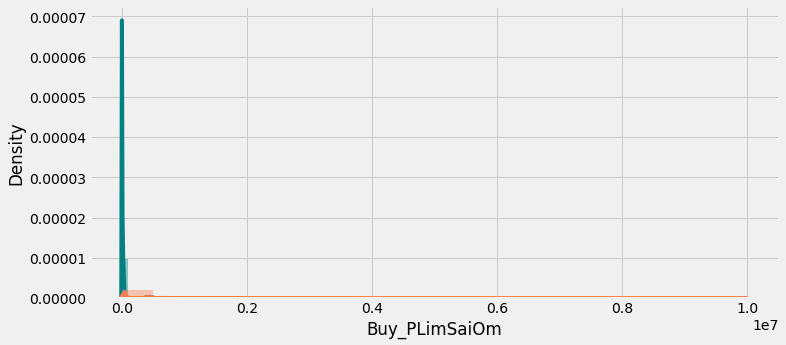

In [6]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11, 5))
sns.distplot(data3['sell_PLimSaiOm'], kde=True,bins=20,  color='teal')
sns.distplot(data3['Buy_PLimSaiOm'], kde=True,bins=20,  color='coral')

#### *IRO3JPPZ0001*

In [ ]:
data = data3.copy()

In [ ]:
data = data[data.InstrumentID=='IRO3JPPZ0001']
data.set_index('datetime', drop=True, append=False, inplace=True, verify_integrity=False)
display(data.head())

data = data.sort_index()
data.head(22)

In [ ]:
sns.set(font_scale=2)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 15))
data.PTran.plot(label='Raw', color='teal', lw=3)
data.PTran.rolling(24).mean().plot(label='roll4 MA', color='coral', lw=5)
#d.PTran.expanding().mean().plot(label='Expanding Average', color='orangered', lw=1)
data.PTran.ewm(alpha=0.03).mean().plot(label='EWMA($\\alpha=.03$)', color='k', lw=1)

plt.legend(bbox_to_anchor=(1.25, .5))
#plt.tight_layout()
plt.ylabel("PTran (R)")



In [ ]:
sns.set(font_scale=2)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 15))
data.Price.plot(label='Raw', color='teal', lw=3)
data.Price.rolling(24).mean().plot(label='roll4 MA', color='coral', lw=5)
#d.PTran.expanding().mean().plot(label='Expanding Average', color='orangered', lw=1)
data.Price.ewm(alpha=0.03).mean().plot(label='EWMA($\\alpha=.03$)', color='k', lw=1)

plt.legend(bbox_to_anchor=(1.25, .5))
#plt.tight_layout()
plt.ylabel("PTran (R)")



In [ ]:
sns.set(font_scale=2)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 15))
data.QTitTran.plot(label='Raw', color='teal', lw=3)
data.QTitTran.rolling(24).mean().plot(label='roll4 MA', color='coral', lw=5)
#d.PTran.expanding().mean().plot(label='Expanding Average', color='orangered', lw=1)
data.QTitTran.ewm(alpha=0.03).mean().plot(label='EWMA($\\alpha=.03$)', color='k', lw=1)

plt.legend(bbox_to_anchor=(1.25, .5))
#plt.tight_layout()
plt.ylabel("PTran (R)")



In [ ]:
sns.set()
plt.style.use('seaborn-poster')
plt.figure(figsize=(17, 10))
dd.PTran.plot(label='Raw', color='k', lw=3)
dd.PTran.rolling(4).mean().plot(label='4h MA', color='red', lw=2)
dd.PTran.expanding().mean().plot(label='Expanding Average', lw=2)
dd.PTran.ewm(alpha=0.03).mean().plot(label='EWMA($\\alpha=.03$)', color='darkred', lw=2)

plt.legend(bbox_to_anchor=(1.25, .5))
#plt.tight_layout()
plt.ylabel("PTran ($)")
sns.despine()
plt.figure(figsize=(17, 10))
roll = dd.PTran.rolling(2, center=True)
m = roll.agg(['mean', 'std'])
ax = m['mean'].plot(color='teal')
ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'],
                alpha=.25, color='red', lw=5)
plt.tight_layout()
plt.ylabel("PTrans ($)")
#sns.despine()

#### *IRO7HPKP0001*